# Imports and downloads

In [2]:
import os
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
#Download the dataset
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

--2020-08-27 03:54:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  66.7MB/s    in 1.0s    

2020-08-27 03:54:29 (66.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
#Download the weights from the trained model.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-27 03:54:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  37.3MB/s    in 2.2s    

2020-08-27 03:54:32 (37.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Pre-trained Inception model

In [5]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Instanciate the pretrained model with the required input shape
#weights specifies that we want to use our weights (the ones that we have just downloaded)
#include_top indicates if we want to use the fully connected layers

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

#We indicate that every layer of our Inception model won't be trained
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
#We can grab any output of the trained layers.
#In this example we will use mixed7
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Model

In [7]:
#Now we define our model, using as an input the last layer of the trained model
#and leaving only one hidden layer trainable, and of course, the output layer.
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [8]:
#Train image generator with data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

#Validation generator
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 18s - loss: 0.3215 - accuracy: 0.8725 - val_loss: 0.1728 - val_accuracy: 0.9330
Epoch 2/20
100/100 - 18s - loss: 0.2254 - accuracy: 0.9125 - val_loss: 0.0983 - val_accuracy: 0.9590
Epoch 3/20
100/100 - 17s - loss: 0.1944 - accuracy: 0.9230 - val_loss: 0.0776 - val_accuracy: 0.9690
Epoch 4/20
100/100 - 17s - loss: 0.1990 - accuracy: 0.9260 - val_loss: 0.0861 - val_accuracy: 0.9690
Epoch 5/20
100/100 - 17s - loss: 0.1466 - accuracy: 0.9425 - val_loss: 0.1025 - val_accuracy: 0.9700
Epoch 6/20
100/100 - 17s - loss: 0.1468 - accuracy: 0.9495 - val_loss: 0.1984 - val_accuracy: 0.9400
Epoch 7/20
100/100 - 17s - loss: 0.1417 - accuracy: 0.9490 - val_loss: 0.1107 - val_accuracy: 0.9710
Epoch 8/20
100/100 - 17s - loss: 0.1717 - accuracy: 0.9400 - val_loss: 0.1130 - val_accuracy: 0.9650
Epoch 9/20
100/100 - 17s - loss: 0.1373 - accuracy: 0.9550 - val_loss: 0.1056 - val_accuracy: 0.9670
Epoch 10/20
100/100 - 17s - loss: 0.1392 - accuracy: 0.9520 - val_loss: 0.1169 - val_accura

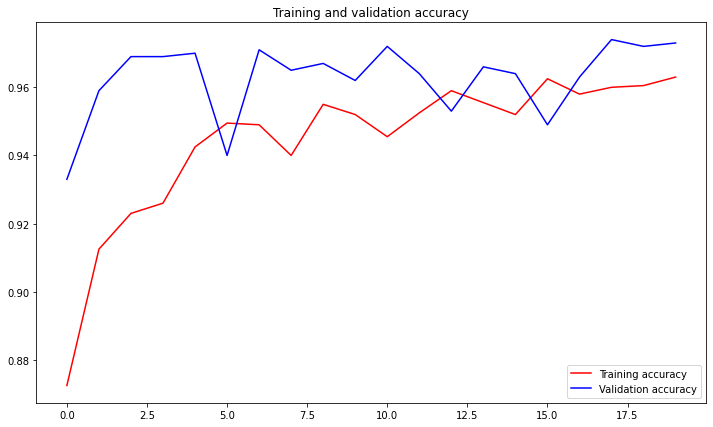

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,7))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()